In [1]:
!python -V
# !pip list
# /content/drive/MyDrive/Colab Notebooks/Indian_Currency/dataset.zip
# https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
# https://github.com/rowhitswami/Indian-Paper-Currency-Classification/blob/master/processing/__init__.py
# https://www.kaggle.com/datasets/gauravsahani/indian-currency-notes-classifier/data
# https://www.kaggle.com/code/aadarshraj4444/indian-currency-notes-classifier


Python 3.10.11


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Indian_Currency/dataset1.zip", 'r')
zip_ref.extractall()
zip_ref.close()

print('done...')

done...


In [ ]:
!nvidia-smi

Tue Oct 24 06:59:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6204893e-d48f-251a-f378-daf52780e0cb)


In [ ]:
# import the libraries as shown below
import numpy as np
import pandas as pd
from glob import glob
import os
import time
import shutil

from tensorflow import keras

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model

from keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/dataset/Train'
valid_path = '/content/dataset/Test'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob(train_path+'/*')
folders

['/content/dataset/Train/3',
 '/content/dataset/Train/1',
 '/content/dataset/Train/2',
 '/content/dataset/Train/4',
 '/content/dataset/Train/5',
 '/content/dataset/Train/0']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg16_model.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16_model.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Checkpoint's
# https://keras.io/api/callbacks/model_checkpoint/

filepath="Indian_Currency_Notes_Classifier_model_vgg16-{epoch:02d}-{val_accuracy:.3f}-{val_loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True
                            #  mode='min'
                             )
callbacks_list = [checkpoint]

In [ ]:
# Use the Image Data Generator to import the images from the dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 846 images belonging to 6 classes.
Found 183 images belonging to 6 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute

start = time.time()

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks_list
)
print('\n\n')
print(f'Time: {time.time() - start}')

model.save('VGG16_model.h5')

<ipython-input-16-fa3a9a51e52f>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.4726 - accuracy: 0.4823
Epoch 1: val_loss improved from inf to 0.73568, saving model to Indian_Currency_Notes_Classifier_model_vgg16-01-0.770-0.736.h5
27/27 [==============================] - 36s 864ms/step - loss: 1.4726 - accuracy: 0.4823 - val_loss: 0.7357 - val_accuracy: 0.7705


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8723
Epoch 2: val_loss improved from 0.73568 to 0.25146, saving model to Indian_Currency_Notes_Classifier_model_vgg16-02-0.951-0.251.h5
27/27 [==============================] - 18s 656ms/step - loss: 0.4448 - accuracy: 0.8723 - val_loss: 0.2515 - val_accuracy: 0.9508
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9610
Epoch 3: val_loss improved from 0.25146 to 0.17887, saving model to Indian_Currency_Notes_Classifier_model_vgg16-03-0.967-0.179.h5
27/27 [==============================] - 17s 629ms/step - loss: 0.2107 - accuracy: 0.9610 - val_loss: 0.1789 - val_accuracy: 0.9672
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9823
Epoch 4: val_loss improved from 0.17887 to 0.12511, saving model to Indian_Currency_Notes_Classifier_model_vgg16-04-0.978-0.125.h5
27/27 [==============================] - 18s 652ms/step - los

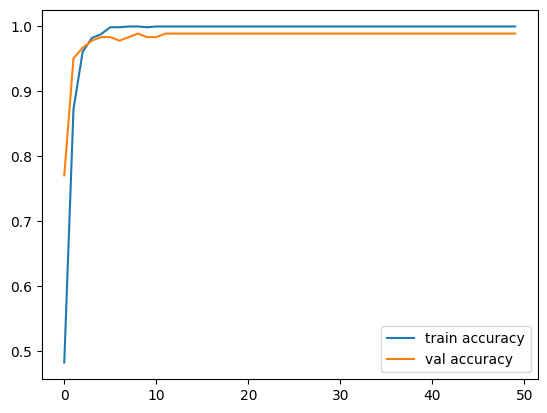

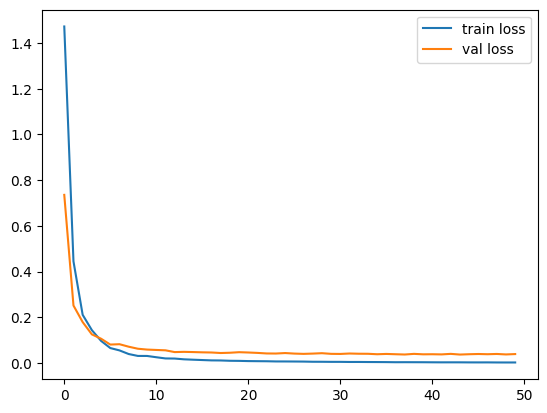

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()


In [ ]:
from glob import glob
import os

model = load_model('/content/Indian_Currency_Notes_Classifier_model_vgg16-44-0.989-0.037.h5')
# model.summary()

data = []
labels = []
classes = glob(valid_path+'/*') # data/train/* # data/test/*
# print('Number of classes : ', len(classes), classes)
cur_path = os.getcwd()
# print('cur_path : ', cur_path)


from PIL import Image

# Retrieving the images and their labels
for i in range(len(classes)):
    path = os.path.join(valid_path, str(i))
    # print('path : ', path)
    images = os.listdir(path)
    # print('images : ',images)

    for a in images:
        try:
            image = Image.open(path +'/'+ a)
            image = image.resize((224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
print('loaded ...')



y_true = []
y_pred = []

for i in range(len(data)):
    x = data[i]
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    classes = model.predict(img_data)
    li = list(classes[0])
    y_pred.append(li.index(max(li)))
    y_true.append(labels[i])

    print('y_true : ', y_true[i], ' y_pred : ', y_pred[i])

print('done...')


loaded ...
1/1 [==============================] - 0s 145ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 21ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 18ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 17ms/step
y_true :  0  y_pred :  5
1/1 [==============================] - 0s 17ms/step
y_true :  0  y_pred :  0
1/1 [==============================] - 0s 18ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 17ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 19ms/step
y_true :  0  y_pred :  2
1/1 [==============================] - 0s 20ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 20ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 18ms/step
y_true :  0  y_pred :  0
1/1 [==============================] - 0s 18ms/step
y_true :  0  y_pred :  4
1/1 [==============================] - 0s 17ms/step
y_true :  0 

InvalidArgumentError: ignored

[[0 2 1 0 3 0]
 [1 2 1 0 1 1]
 [2 0 2 0 2 0]
 [1 0 0 0 2 3]
 [3 0 2 0 1 0]
 [0 1 1 0 1 3]] 

Accuracy: 0.222222 

Error rate: 0.777778 

classification_report 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      0.33      0.36         6
           2       0.29      0.33      0.31         6
           3       0.00      0.00      0.00         6
           4       0.10      0.17      0.12         6
           5       0.43      0.50      0.46         6

    accuracy                           0.22        36
   macro avg       0.20      0.22      0.21        36
weighted avg       0.20      0.22      0.21        36
 

Cohens kappa: 0.066667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


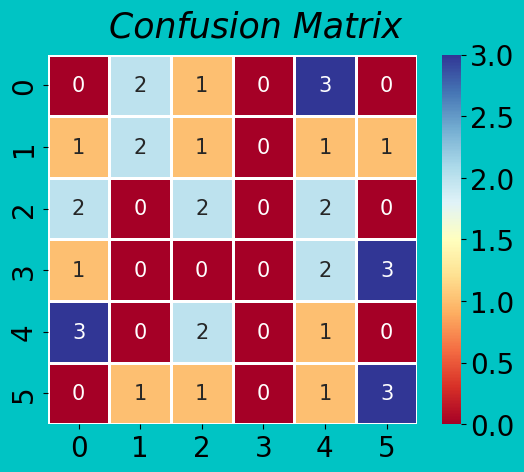

In [ ]:
  # confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true,y_pred)
print(matrix, '\n')

# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')

from sklearn.metrics import classification_report
print("classification_report \n\n", classification_report(y_true,y_pred), '\n')

# kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true,y_pred)
print('Cohens kappa: %f' % kappa)

# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

plt.rcParams['font.size'] = 20
bg_color = (0,0.77,0.77)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

fig, ax = plt.subplots(1)

plt.text(1,-.3, "Confusion Matrix", fontsize = 25, color='Black', fontstyle='italic')

ax = sns.heatmap(matrix, annot=True, annot_kws={'size':15}, fmt="d",
                 robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# vmin=0, vmax=350,
plt.savefig("model_VGG19.jpeg", dpi=200, facecolor=bg_color, transparent=True)
plt.show()


# ResNet50_model

In [ ]:
# import the libraries as shown below
import numpy as np
import pandas as pd
from glob import glob
import os
import time
import shutil

from tensorflow import keras

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model

from keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/dataset/Train'
valid_path = '/content/dataset/Test'


# Import the ResNet50 library as shown below and add preprocessing layer to the front of ResNet50
# Here we will be using imagenet weights

ResNet50_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in ResNet50_model.layers:
    layer.trainable = False

# useful for getting number of output classes
folders = glob(train_path+'/*')
folders


94765736/94765736 [==============================] - 0s 0us/step


['/content/dataset/Train/3',
 '/content/dataset/Train/1',
 '/content/dataset/Train/2',
 '/content/dataset/Train/4',
 '/content/dataset/Train/5',
 '/content/dataset/Train/0']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(ResNet50_model.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=ResNet50_model.input, outputs=prediction)

# view the structure of the model
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Checkpoint's
# https://keras.io/api/callbacks/model_checkpoint/

filepath="Indian_Currency_Notes_Classifier_model_ResNet50-{epoch:02d}-{val_accuracy:.3f}-{val_loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True
                            #  mode='min'
                             )
callbacks_list = [checkpoint]


In [ ]:
# Use the Image Data Generator to import the images from the dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)



# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')




Found 846 images belonging to 6 classes.
Found 183 images belonging to 6 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute

start = time.time()

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks_list
)
print('\n\n')
print(f'Time: {time.time() - start}')

model.save('ResNet50_model.h5')


<ipython-input-30-37865a269b69>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.8345
Epoch 1: val_loss improved from 0.38549 to 0.38381, saving model to Indian_Currency_Notes_Classifier_model_ResNet50-01-0.902-0.384.h5
27/27 [==============================] - 18s 654ms/step - loss: 0.4751 - accuracy: 0.8345 - val_loss: 0.3838 - val_accuracy: 0.9016
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8357
Epoch 2: val_loss did not improve from 0.38381
27/27 [==============================] - 18s 644ms/step - loss: 0.4819 - accuracy: 0.8357 - val_loss: 0.4504 - val_accuracy: 0.8470
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8463
Epoch 3: val_loss did not improve from 0.38381
27/27 [==============================] - 18s 674ms/step - loss: 0.4131 - accuracy: 0.8463 - val_loss: 0.4179 - val_accuracy: 0.8852
Epoch 4/30
27/27 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8794


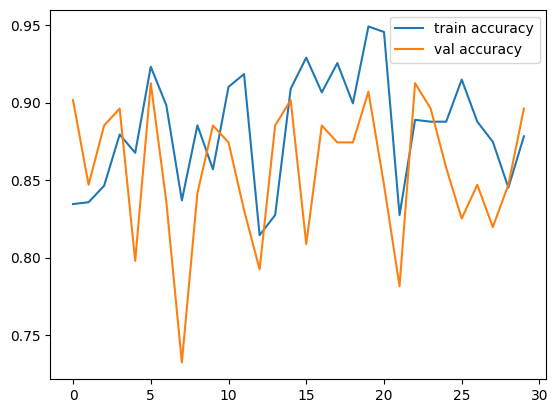

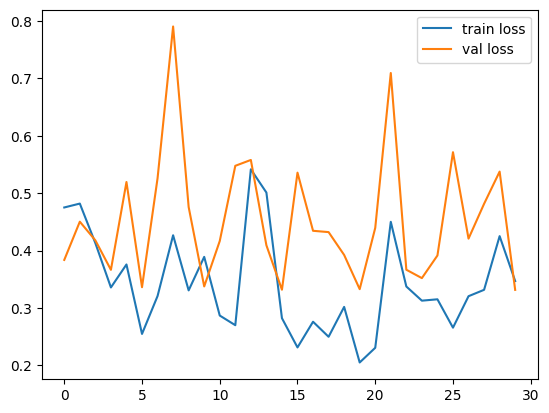

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()



In [ ]:
# /content/Indian_Currency_Notes_Classifier_model_ResNet50-15-0.902-0.332.h5
from glob import glob
import os

model = load_model('/content/Indian_Currency_Notes_Classifier_model_ResNet50-15-0.902-0.332.h5')
# model.summary()

data = []
labels = []
classes = glob(train_path+'/*') # data/train/* # data/test/*
# print('Number of classes : ', len(classes), classes)
cur_path = os.getcwd()
# print('cur_path : ', cur_path)


from PIL import Image

# Retrieving the images and their labels
for i in range(len(classes)):
    path = os.path.join(valid_path, str(i))
    # print('path : ', path)
    images = os.listdir(path)
    # print('images : ',images)

    for a in images:
        try:
            image = Image.open(path +'/'+ a)
            image = image.resize((224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
print('loaded ...')


y_true = []
y_pred = []

for i in range(len(data)):
    x = data[i]
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    classes = model.predict(img_data)
    li = list(classes[0])
    y_pred.append(li.index(max(li)))
    y_true.append(labels[i])

    print('y_true : ', y_true[i], ' y_pred : ', y_pred[i])

print('done...')



loaded ...
1/1 [==============================] - 1s 910ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 24ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 24ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 22ms/step
y_true :  0  y_pred :  2
1/1 [==============================] - 0s 23ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 24ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 22ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 22ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 27ms/step
y_true :  0  y_pred :  2
1/1 [==============================] - 0s 28ms/step
y_true :  0  y_pred :  2
1/1 [==============================] - 0s 23ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 23ms/step
y_true :  0  y_pred :  1
1/1 [==============================] - 0s 25ms/step
y_true :  0 

InvalidArgumentError: ignored

# @14/11/2023

# Currency Classification using ResNet50 / MobileNet

In [ ]:
!python -V

Python 3.10.12


In [ ]:
# Check GPU
!nvidia-smi

Tue Nov 14 07:37:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fddb8f03-552a-28e9-aaf9-6f847e3a1f6c)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Indian_Currency/Indian_currency_dataset_v1.zip", 'r')
zip_ref.extractall()
zip_ref.close()

print('done...')

done...


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#import basic essential libraries
import matplotlib.pyplot as plt
# import path
import os
%matplotlib inline

In [ ]:
# import  keras libraries to build model and conv net
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from pathlib import Path

# load dataset and image agumentaion

In [ ]:
# current dataset only has 4k images
# so image agumentation to virtually increase size of dataset
# help (ImageDataGenerator?)

import keras
from keras.preprocessing.image import ImageDataGenerator

data_agumentation = ImageDataGenerator(rescale=0./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )

# load training data
train_data = data_agumentation.flow_from_directory(directory='/content/training',
                                                   target_size=(256,256),
                                                   class_mode='categorical',
                                                   batch_size=32
                                                   )

Found 3566 images belonging to 8 classes.


In [ ]:
#load validation data
val_data = ImageDataGenerator().flow_from_directory(directory='/content/validation',
                                                    target_size=(256,256),
                                                    class_mode='categorical'
                                                    )

Found 345 images belonging to 8 classes.


# Model

## Early stopping and callback

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint monitors  the given parameter and save the model automatically
# here given parameter to monitor is val_loss
# it moniters the  val loss of each epoch and val_loss is lower than previous one it save the current model ad wieght

checkpoint = ModelCheckpoint("currency_detector_smal_model.h5",
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto'
                            #  save_freq = 1
                             )

# early stopping .. it stops the trainng phase if there is no improvement in the model
# patience defines how many epoch can b ignored before forcefully stoping the model

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0,
                      patience = 10,
                      verbose = 1,
                      mode = 'auto'
                      )

## define model add layers and compile

In [ ]:
# import ResNet50

from keras.applications import ResNet50

# total number of classes (7 diffferent currency and 1 background class)
num_classes = 8

# load the weight
# resnet_weights_path = '/content/drive/MyDrive/Colab Notebooks/Indian_Currency/currency_detector_2.4GB_earlyStopping_model.h5'

#define the mdel
my_new_model = Sequential()

# add the resnet to new defined model
my_new_model.add(ResNet50(include_top=False,
                          pooling='avg',
                          # weights=resnet_weights_path
                          ))

#last fully connected layer with softmax as a activation function
my_new_model.add(Dense(num_classes, activation='softmax'))

my_new_model.layers[0].trainable = False

# compile the model with adam optimizer, categorical_croosentropy loss function
my_new_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

## Fit the model with train and val dataset

In [ ]:
# fit the model with train data and validation data
# epoch 50
my_new_model.fit_generator(train_data,
                           epochs = 50,
                           validation_data=val_data,
                           callbacks=[checkpoint,early])

<ipython-input-18-bb18a9b0e59e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  my_new_model.fit_generator(train_data,


Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 1.3709 - accuracy: 0.5213
Epoch 1: val_loss improved from inf to 0.87172, saving model to currency_detector_smal_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 206s 2s/step - loss: 1.3709 - accuracy: 0.5213 - val_loss: 0.8717 - val_accuracy: 0.7304
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.7602
Epoch 2: val_loss improved from 0.87172 to 0.66227, saving model to currency_detector_smal_model.h5
112/112 [==============================] - 184s 2s/step - loss: 0.7715 - accuracy: 0.7602 - val_loss: 0.6623 - val_accuracy: 0.7855
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.8051
Epoch 3: val_loss improved from 0.66227 to 0.60425, saving model to currency_detector_smal_model.h5
112/112 [==============================] - 188s 2s/step - loss: 0.6165 - accuracy: 0.8051 - val_loss: 0.6043 - val_accuracy: 0.7971
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.8317
Epoch 4: val_loss improved from 0.60425 to 0.51980, saving model to currency_detector_smal_model.h5
112/112 [=======

## save model into JSON

In [ ]:
# save the json model

model_json = my_new_model.to_json()
with open("resnet_50_model.json", "w") as json_file:
    json_file.write(model_json)

# predication

## class labels

In [ ]:
# These are the  class labels from the training data (Each number stands for the currency denomination)
class_labels = [
    '10','100','20','200','2000','50','500','Background'
]

## Show images

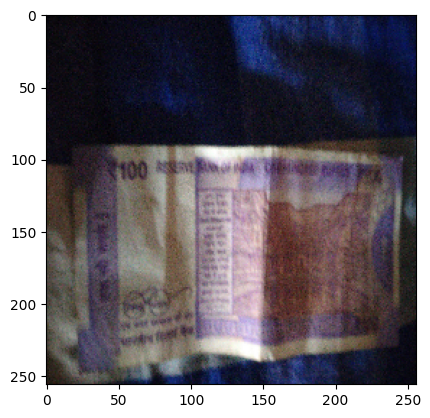

In [ ]:
# Load an image file to test, resizing it to 256x256 pixels
# to save time in training I resize images to 256x256

from keras.preprocessing import image

img = image.load_img("/content/validation/100/100_val_38.jpg", target_size=(256,256))
plt.imshow(img)

# code for prediction

In [ ]:
# Convert the image to a numpy array
from keras.preprocessing import image

def prediction(file_name):
    img = image.load_img(file_name, target_size=(256,256))

    image_to_test = image.img_to_array(img)

    # Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
    list_of_images = np.expand_dims(image_to_test, axis=0)

    # Make a prediction using the model
    results = my_new_model.predict(list_of_images)

    # Since we are only testing one image, we only need to check the first result
    single_result = results[0]

    # We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
    most_likely_class_index = int(np.argmax(single_result))
    class_likelihood = single_result[most_likely_class_index]

    # Get the name of the most likely class
    class_label = class_labels[most_likely_class_index]

    # Print the result
    print(file_name)
    print("This is image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))

## predicting the test images

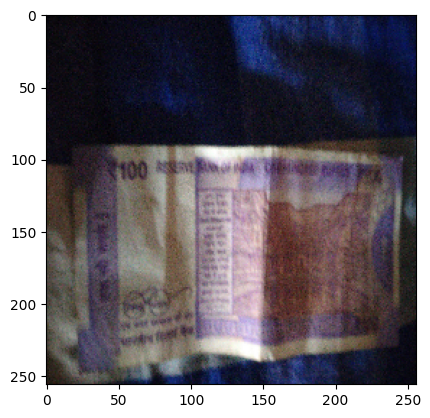

In [ ]:
from keras.preprocessing import image
img = image.load_img("/content/validation/100/100_val_38.jpg", target_size=(256,256))
plt.imshow(img)

In [ ]:
import glob
# Find all *.jpg files in the directory
file_name_list = glob.glob('/content/validation/100/100_val_38.jpg')
print(len(file_name_list))
for file_name in file_name_list:
    prediction(file_name)

1
1/1 [==============================] - 32s 32s/step
/content/validation/100/100_val_38.jpg
This is image is a 100 - Likelihood: 0.528051


In [ ]:
import glob
# Find all *.jpg files in the directory
file_name_list = glob.glob('/content/validation/100/*.jpg')
print(len(file_name_list))
for file_name in file_name_list:
    prediction(file_name)

45
1/1 [==============================] - 0s 43ms/step
/content/validation/100/100_val_17.jpg
This is image is a 100 - Likelihood: 0.856837
1/1 [==============================] - 0s 60ms/step
/content/validation/100/100_val_43.jpg
This is image is a 100 - Likelihood: 0.998905
1/1 [==============================] - 0s 35ms/step
/content/validation/100/100_val_33.jpg
This is image is a 100 - Likelihood: 0.993027
1/1 [==============================] - 0s 73ms/step
/content/validation/100/100_val_34.jpg
This is image is a 100 - Likelihood: 0.999912
1/1 [==============================] - 0s 81ms/step
/content/validation/100/100_val_22.jpg
This is image is a 100 - Likelihood: 0.707047
1/1 [==============================] - 0s 79ms/step
/content/validation/100/100_val_2.jpg
This is image is a 50 - Likelihood: 0.624852
1/1 [==============================] - 0s 41ms/step
/content/validation/100/100_val_15.jpg
This is image is a 100 - Likelihood: 0.999943
1/1 [==============================] - 0

In [ ]:
import glob
# Find all *.jpg files in the directory
file_name_list = glob.glob('/content/validation/10/*.jpg')
print(len(file_name_list))
for file_name in file_name_list:
    prediction(file_name)

45
1/1 [==============================] - 0s 187ms/step
/content/validation/10/10_val_6.jpg
This is image is a 10 - Likelihood: 0.997009
1/1 [==============================] - 0s 120ms/step
/content/validation/10/10_val_10.jpg
This is image is a 10 - Likelihood: 0.977432
1/1 [==============================] - 0s 62ms/step
/content/validation/10/10_val_9.jpg
This is image is a 10 - Likelihood: 0.776486
1/1 [==============================] - 0s 39ms/step
/content/validation/10/10_val_8.jpg
This is image is a 10 - Likelihood: 0.998352
1/1 [==============================] - 0s 44ms/step
/content/validation/10/10_val_0.jpg
This is image is a 10 - Likelihood: 0.998552
1/1 [==============================] - 0s 40ms/step
/content/validation/10/10_val_30.jpg
This is image is a 10 - Likelihood: 0.736693
1/1 [==============================] - 0s 39ms/step
/content/validation/10/10_val_26.jpg
This is image is a 50 - Likelihood: 0.527289
1/1 [==============================] - 0s 41ms/step
/content/

In [ ]:
import glob
# Find all *.jpg files in the directory
file_name_list = glob.glob('/content/validation/20/*.jpg')
print(len(file_name_list))
for file_name in file_name_list:
    prediction(file_name)

45
1/1 [==============================] - 0s 26ms/step
/content/validation/20/20_val_13.jpg
This is image is a 20 - Likelihood: 0.973254
1/1 [==============================] - 0s 24ms/step
/content/validation/20/20_val_22.jpg
This is image is a 20 - Likelihood: 0.988861
1/1 [==============================] - 0s 40ms/step
/content/validation/20/20_val_34.jpg
This is image is a 20 - Likelihood: 0.975797
1/1 [==============================] - 0s 45ms/step
/content/validation/20/20_val_1.jpg
This is image is a 20 - Likelihood: 0.740538
1/1 [==============================] - 0s 39ms/step
/content/validation/20/20_val_6.jpg
This is image is a 20 - Likelihood: 0.984814
1/1 [==============================] - 0s 39ms/step
/content/validation/20/20_val_21.jpg
This is image is a 20 - Likelihood: 0.859356
1/1 [==============================] - 0s 41ms/step
/content/validation/20/20_val_16.jpg
This is image is a 20 - Likelihood: 0.870213
1/1 [==============================] - 0s 45ms/step
/content/

In [ ]:
import glob
# Find all *.jpg files in the directory
file_name_list = glob.glob('/content/validation/Background/*.jpg')
print(len(file_name_list))
for file_name in file_name_list:
    prediction(file_name)

30
1/1 [==============================] - 0s 58ms/step
/content/validation/Background/Background_val_9.jpg
This is image is a Background - Likelihood: 0.970629
1/1 [==============================] - 0s 36ms/step
/content/validation/Background/Background_val_22.jpg
This is image is a Background - Likelihood: 0.999139
1/1 [==============================] - 0s 44ms/step
/content/validation/Background/Background_val_19.jpg
This is image is a Background - Likelihood: 0.994664
1/1 [==============================] - 0s 44ms/step
/content/validation/Background/Background_val_16.jpg
This is image is a Background - Likelihood: 0.917100
1/1 [==============================] - 0s 40ms/step
/content/validation/Background/Background_val_26.jpg
This is image is a Background - Likelihood: 0.992601
1/1 [==============================] - 0s 44ms/step
/content/validation/Background/Background_val_28.jpg
This is image is a Background - Likelihood: 0.999869
1/1 [==============================] - 0s 57ms/ste

In [ ]:
import glob
# Find all *.jpg files in the directory
file_name_list = glob.glob('/content/test/*.jpg')
print(len(file_name_list))
for file_name in file_name_list:
    prediction(file_name)

91
1/1 [==============================] - 0s 34ms/step
/content/test/500__37.jpg
This is image is a 500 - Likelihood: 0.996456
1/1 [==============================] - 0s 38ms/step
/content/test/200.__225.jpg
This is image is a 200 - Likelihood: 0.996744
1/1 [==============================] - 0s 37ms/step
/content/test/200.__143.jpg
This is image is a 200 - Likelihood: 0.948074
1/1 [==============================] - 0s 41ms/step
/content/test/10__206.jpg
This is image is a 50 - Likelihood: 0.621182
1/1 [==============================] - 0s 38ms/step
/content/test/100_20.jpg
This is image is a 100 - Likelihood: 0.648486
1/1 [==============================] - 0s 43ms/step
/content/test/200.__142.jpg
This is image is a 200 - Likelihood: 0.991404
1/1 [==============================] - 0s 37ms/step
/content/test/100__435.jpg
This is image is a 2000 - Likelihood: 0.644579
1/1 [==============================] - 0s 40ms/step
/content/test/20__136.jpg
This is image is a 20 - Likelihood: 0.998173


In [ ]:
'''
Image Augmentation on the fly using Keras ImageDataGenerator!
https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Keras ImageDataGenerator and Data Augmentation
https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

How to use Keras fit and fit_generator (a hands-on tutorial)
https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

'''